In [38]:
# !pip install catboost
# !pip install scikit-optimize

In [39]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', None)

%matplotlib inline

In [40]:
def read_file(url):
  url = url + "?raw=true"
  df = pd.read_csv(url)
  return df

url = "https://github.com/andbren/TDT-4173/blob/main/apartments_train.csv"
apartments = read_file(url)

url = "https://github.com/andbren/TDT-4173/blob/main/buildings_train.csv"
buildings = read_file(url)

print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

All apartments have an associated building: True


In [41]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

def evaluate_predictions(predictions: pd.DataFrame, y_true: pd.DataFrame):
    """Evaluate predictions, the same way as done when uploading to Kaggle.

    Args:
      predictions: pandas DataFrame with predictions. Should be in the same
        order as the True data.
    
    Example:
      >>> # model = a previously trained model
      >>> results = model.predict(X_valid)
      >>> score = evaluate_predictions(results, y_valid)
    """
    return root_mean_squared_log_error(y_true, predictions)

In [42]:
# Add price bins, to sort and later split data
NUM_BUCKETS = 10
log_price = np.log10(data['price'])

price_bin_max = log_price.max()
price_bin_min = log_price.min()
price_bin_size = (price_bin_max - price_bin_min) / NUM_BUCKETS

price_bins = [
    i*price_bin_size + price_bin_min for i in range(NUM_BUCKETS)
]
labels = [i for i in range(len(price_bins) - 1)]

data['price_bin'] = pd.cut(log_price, bins=price_bins, labels=labels)
data["price_bin"].fillna(8, inplace=True)


# Preprocessing

In [43]:
# Fill in missing values
default_values = {   
    "seller": 4,          # Add a new category to seller - UNKNOWN = 4
    "area_kitchen": np.median(data["area_kitchen"].dropna()),
    "area_living": np.median(data["area_living"].dropna()),
    "layout": 3,          # Add a new category to layout - UNKNOWN = 3
    "ceiling": np.median(data["ceiling"].dropna()),
    "bathrooms_shared": 0,
    "bathrooms_private": 0,
    "windows_court": 2,   # Change "windows_court" to categorical. New category - UNKNOWN = 2
    "windows_street": 2,  # Change "windows_street" to categorical. New category - UNKNOWN = 2
    "balconies": 0,
    "loggias": 0,
    "condition": 4,       # Add a new category to condition - UNKNOWN = 4
    "phones": 0,
    "new": 2,             # Change "new" to be categorical. New category - UNKNOWN = 2
    "district": 12,       # Add new category to district - UNKNOWN = 12
    "constructed": np.median(data["constructed"].dropna()),
    "material": 7,        # Add new category to material - UNKNOWN = 7
    "elevator_without": 0,
    "elevator_passenger": 0,
    "elevator_service": 0,
    "parking": 3,         # Add new category to parking - UNKNOWN = 3
    "garbage_chute": 0,
    "heating": 4,         # Add new category to heating - UNKNOWN = 4
}

data.fillna(value=default_values, inplace = True)

# Feature engineering

In [44]:
# Convert latitude, longitude to polar coordinates
def cartesian_to_polar_coordinates(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
    
geographical_weighted_center_latitude = np.average(data["latitude"], weights=data["price_bin"])
geographical_weighted_center_longitude = np.average(data["longitude"], weights=data["price_bin"])

delta_latitude = data["latitude"] - geographical_weighted_center_latitude
delta_longitude = data["longitude"] - geographical_weighted_center_longitude

data["distance_from_center"], data["angle"] = cartesian_to_polar_coordinates(delta_latitude, delta_longitude)

In [45]:
# Convert boolean and categorical values to their right types
needed_dtypes = {
    "seller": CategoricalDtype(categories=[0, 1, 2, 3, 4]),
    "floor": "uint8",
    "rooms": "uint8",
    "layout": CategoricalDtype(categories=[0, 1, 2, 3]),
    "bathrooms_shared": "uint8",
    "bathrooms_private": "uint8",
    "windows_court": CategoricalDtype(categories=[0, 1, 2]),
    "windows_street": CategoricalDtype(categories=[0, 1, 2]),
    "balconies": "uint8",
    "loggias": "uint8",
    "condition": CategoricalDtype(categories=[0, 1, 2, 3, 4]),
    "phones": "uint8",
    "new": CategoricalDtype(categories=[0, 1, 2]),
    "district": CategoricalDtype(categories=list(range(13))),
    "constructed": "uint16",
    "material": CategoricalDtype(categories=list(range(8))),
    "stories": "uint8",
    "elevator_without": "bool",
    "elevator_passenger": "bool",
    "elevator_service": "bool",
    "parking": CategoricalDtype(categories=[0, 1, 2, 3]),
    "garbage_chute": "bool",
    "heating": CategoricalDtype(categories=[0, 1, 2, 3, 4]),
}
data = data.astype(needed_dtypes)

In [46]:
url = "https://github.com/andbren/TDT-4173/blob/main/apartments_test.csv"
apartments_test = read_file(url)

url = "https://github.com/andbren/TDT-4173/blob/main/buildings_test.csv"
buildings_test = read_file(url)

print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)

data_test.fillna(value=default_values, inplace = True)
data_test = data_test.astype(needed_dtypes)

All apartments have an associated building: True


In [47]:
# Remove outliers in data
data.drop(data.index[data["price"] > 1.5e9], inplace=True)
data.drop(data.index[(data["price"] > 0.5e9) & (data["seller"] == 1)], inplace=True)
data.drop(data.index[data["area_living"] > 600], inplace=True)
data.drop(data.index[(data["price"] > 0.5e9) & (data["constructed"] > 1900) & (data["constructed"] < 1925)], inplace=True,)
data.reset_index(inplace=True, drop=True)

In [59]:
# Transform extreme outliers in data_test
data_test.loc[data_test["latitude"] < 50, "latitude"] = data_test[data_test["latitude"] >= 50]["latitude"].min()
data_test.loc[data_test["longitude"] < 30, "longitude"] = data_test[data_test["longitude"] >= 30]["longitude"].min()
data_test.loc[data_test["longitude"] > 40, "longitude"] = data_test[data_test["longitude"] <= 40]["longitude"].max()

data_test.loc[data_test["ceiling"] > 100, "ceiling"] /= 10
data_test.loc[data_test["ceiling"] > 10, "ceiling"] /= 10

#TODO: Same with area_X extremes

In [49]:
delta_latitude = data_test["latitude"] - geographical_weighted_center_latitude
delta_longitude = data_test["longitude"] - geographical_weighted_center_longitude

data_test["distance_from_center"], data_test["angle"] = cartesian_to_polar_coordinates(delta_latitude, delta_longitude)

In [56]:
# Transform wrong values in data
data.loc[data["ceiling"] > 100, "ceiling"] /= 10
data.loc[data["ceiling"] > 10, "ceiling"] /= 10

#TODO: Same with area_X extremes

# Train/test split

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data.drop(["price", "price_bin"], axis=1),
    data["price"],
    test_size = 0.3,
    stratify = data["price_bin"],
)

/home/bolla/repos/tdt4173-machine-learning/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/bolla/repos/tdt4173-machine-learning/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/bolla/repos/tdt4173-machine-learning/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


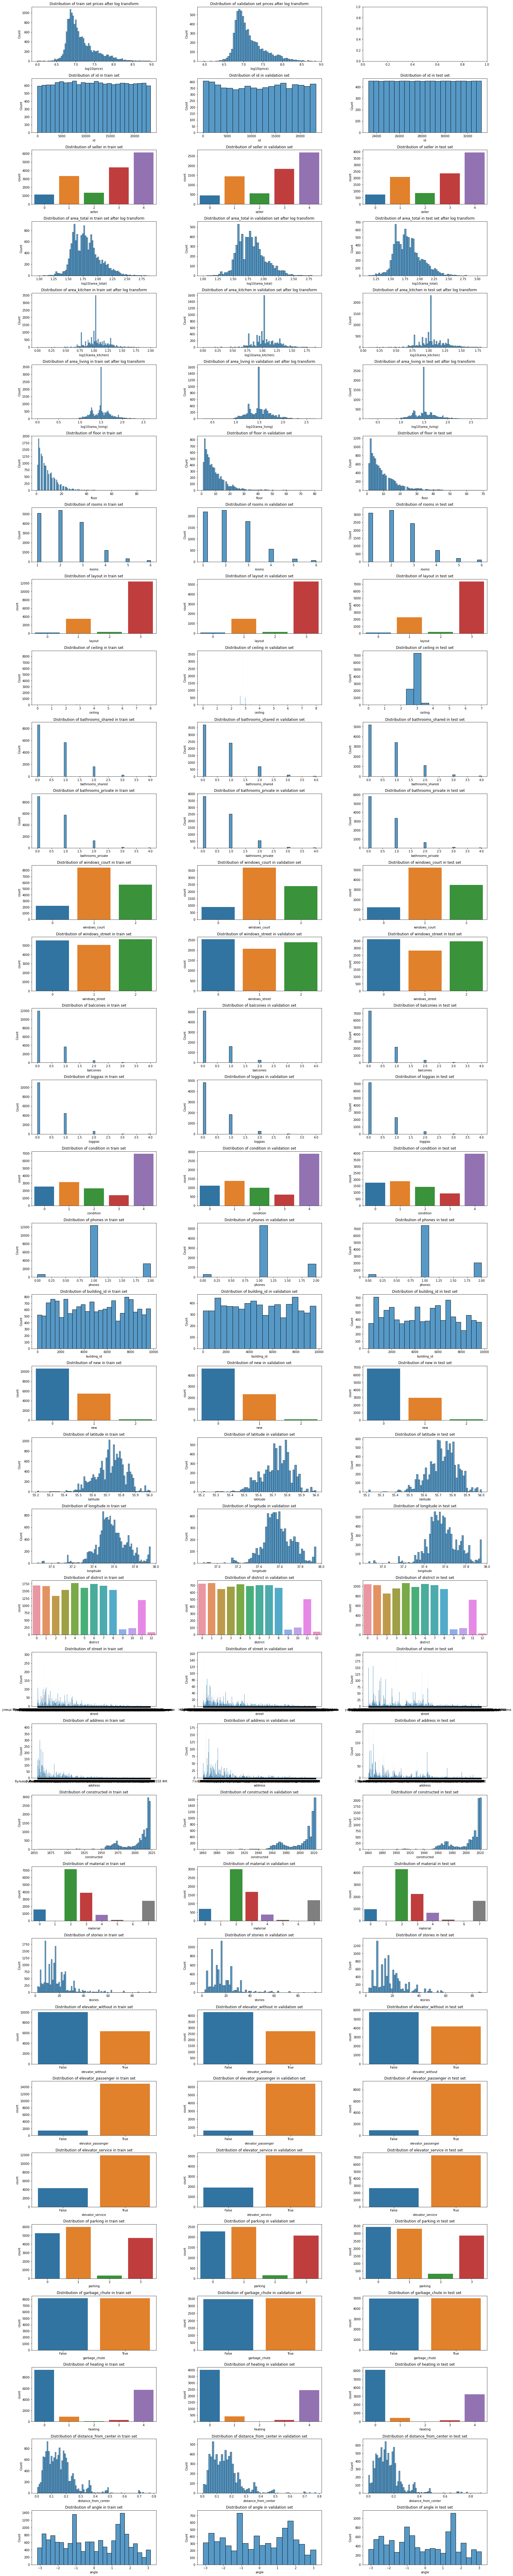

In [63]:
fig, ax = plt.subplots(figsize=(24, 120), ncols=3, nrows=X_train.shape[1]+1, tight_layout={"pad": 1})
sns.histplot(np.log10(y_train).rename('log10(price)'), ax=ax[0, 0])
ax[0, 0].set_title('Distribution of train set prices after log transform')
sns.histplot(np.log10(y_valid).rename('log10(price)'), ax=ax[0, 1])
ax[0, 1].set_title('Distribution of validation set prices after log transform')
for i, column in enumerate(X_train.columns, start=1):
    if column.startswith("area_"):
        sns.histplot(np.log10(X_train[column]).rename(f"log10({column})"), ax=ax[i, 0])
        sns.histplot(np.log10(X_valid[column]).rename(f"log10({column})"), ax=ax[i, 1])
        sns.histplot(np.log10(data_test[column]).rename(f"log10({column})"), ax=ax[i, 2])
        ax[i, 0].set_title(f'Distribution of {column} in train set after log transform')
        ax[i, 1].set_title(f'Distribution of {column} in validation set after log transform')
        ax[i, 2].set_title(f'Distribution of {column} in test set after log transform')
        continue
    if X_train[column].dtype in ("bool", "category"):
        sns.countplot(x=column, data=X_train, ax=ax[i, 0])
        sns.countplot(x=column, data=X_valid, ax=ax[i, 1])
        sns.countplot(x=column, data=data_test, ax=ax[i, 2])
    else:
        sns.histplot(X_train[column], ax=ax[i, 0])
        sns.histplot(X_valid[column], ax=ax[i, 1])
        sns.histplot(data_test[column], ax=ax[i, 2])
    ax[i, 0].set_title(f'Distribution of {column} in train set')
    ax[i, 1].set_title(f'Distribution of {column} in validation set')
    ax[i, 2].set_title(f'Distribution of {column} in test set')

In [ ]:
X_train.to_csv("data/X_train.csv")
X_valid.to_csv("data/X_valid.csv")
y_train.to_csv("data/y_train.csv")
y_valid.to_csv("data/y_valid.csv")
data_test.to_csv("data/test.csv")

Error: Kernel is dead

In [ ]:
fig.savefig("Split distribution.png")